In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from utils import *
import os

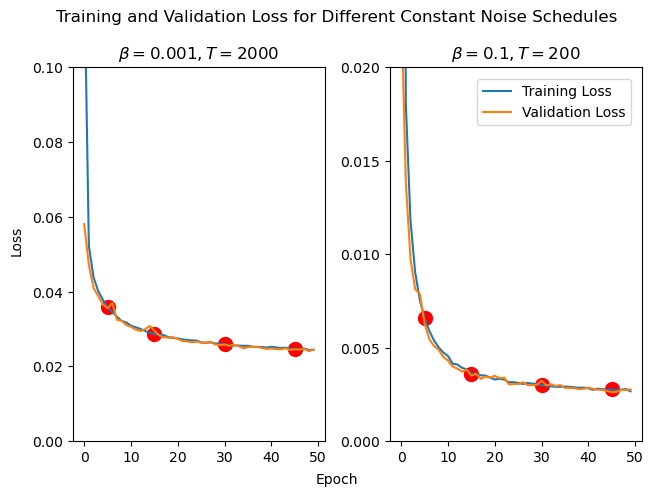

In [33]:
# Q1b
good_run_dir = "../runs/const_q1_good_run"
bad_run_dir = "../runs/const_q1_bad_run"

good_loss_csv = os.path.join(good_run_dir, "losses.csv")
bad_loss_csv = os.path.join(bad_run_dir, "losses.csv")

good_loss_df = pd.read_csv(good_loss_csv)
bad_loss_df = pd.read_csv(bad_loss_csv)

good_train_loss = good_loss_df["avg_training_loss"]
bad_train_loss = bad_loss_df["avg_training_loss"]

good_val_loss = good_loss_df["avg_validation_loss"]
bad_val_loss = bad_loss_df["avg_validation_loss"]


visualise_ts = [5, 15, 30, 45]


fig, ax = plt.subplots(ncols=2)
ax[0].set_title(r"$\beta = 0.001, T=2000$")
ax[0].plot(
    good_train_loss,
)
ax[0].plot(
    good_val_loss,
)
ax[0].set_ylim([0, 0.1])

ax[1].set_title(r"$\beta = 0.1, T=200$")
ax[1].plot(bad_train_loss, label="Training Loss")
ax[1].plot(bad_val_loss, label="Validation Loss")
ax[1].set_ylim([0, 0.02])

for t in visualise_ts:
    ax[0].scatter(t, good_train_loss[t], color="r", s=100)
    ax[1].scatter(t, bad_train_loss[t], color="r", s=100)

fig.legend(bbox_to_anchor=(0.97, 0.85))
# Set y ticks for bad run.
start = 0
end = 0.02
interval = 0.005
ticks = np.arange(start, end + interval, interval)
ax[1].set_yticks(ticks)

# Set common labels
fig.text(0.5, 0.0, "Epoch", ha="center", va="center")  # X-label
fig.text(0.0, 0.5, "Loss", ha="center", va="center", rotation="vertical")  # Y-label

fig.suptitle("Training and Validation Loss for Different Constant Noise Schedules")
plt.tight_layout()
plt.show
plt.savefig("../report/figs/q1b_loss.png", bbox_inches="tight", dpi=300)